In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from labellines import labelLine, labelLines
from matplotlib.pyplot import cm
from importlib import reload

import src.utils as utils

seedno = 123
rng = np.random.default_rng(seed=seedno)

In [2]:
reload(utils)

<module 'src.utils' from '/Users/leandrosb/Documents/GitHub/AMM/src/utils.py'>

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
plt.rc("text", usetex = True)
plt.rc("text.latex", preamble=r'\usepackage{amsmath,amsfonts}')
fs = 16
dpi = 300

In [4]:
depth = 100*1000*1000.
y_0 = 1000

y_grid = np.array([i for i in range(980,1021)])

import pickle

params = { "int_sell": 30., "int_buy": 30., "kappa": 1., "oracleprice": 100., "depth": depth, "y_grid": y_grid, "y_0": y_0, "T": 1., "pen_const": 0.,}

with open("src/params.pkl", "wb") as f:pickle.dump(params,f)

In [5]:
import pickle

with open('src/params.pkl', 'rb') as f:
    params = pickle.load(f)

In [6]:
AMM = utils.AMM(**params)

In [10]:
T= 1
dt = 0.01
Nt = int(T / dt)  # Number of time steps
time = np.linspace(0, T, Nt+1)
num_simulations = 100_000

cash = np.zeros((num_simulations))
n_sell_order = np.zeros((num_simulations))
n_buy_order = np.zeros((num_simulations))
idx_quantity = (np.ones((num_simulations))*[len(AMM.y_grid) // 2]).astype(int)
stoch_int_sell = np.zeros((num_simulations))
stoch_int_buy = np.zeros((num_simulations))
for t in time:
    indicator_plus = ((idx_quantity+1)<len(AMM.y_grid))
    indicator_minus = ((idx_quantity-1)>=0)
    alpha, beta = AMM._calculate_fees_t(t)
    stoch_int_sell = AMM.int_sell * np.exp( AMM.kappa * ((1 - alpha[idx_quantity]) * (AMM.level_fct(AMM.y_grid[idx_quantity]) - AMM.level_fct(AMM.y_grid[idx_quantity+1])) - AMM.oracleprice * AMM.delta_sell(AMM.y_grid, idx_quantity)) ) * indicator_plus
    stoch_int_buy = AMM.int_buy * np.exp( -AMM.kappa * ((1 + beta[idx_quantity]) * (AMM.level_fct(AMM.y_grid[idx_quantity-1]) - AMM.level_fct(AMM.y_grid[idx_quantity])) - AMM.oracleprice * AMM.delta_buy(AMM.y_grid, idx_quantity) ) ) * indicator_minus
    
    sell_order, buy_order = AMM.get_arrival(stoch_int_sell,stoch_int_buy,num_simulations, dt)

    cash += (alpha[idx_quantity] * (AMM.level_fct(AMM.y_grid[idx_quantity]) - AMM.level_fct(AMM.y_grid[idx_quantity+1])) * sell_order.astype(int)) * indicator_plus \
                + ( beta[idx_quantity] * (AMM.level_fct(AMM.y_grid[idx_quantity-1]) - AMM.level_fct(AMM.y_grid[idx_quantity])) * buy_order.astype(int) ) * indicator_minus

    idx_quantity += (sell_order.astype(int) ) *indicator_plus  - (buy_order.astype(int)) * indicator_minus
    n_sell_order += sell_order * indicator_plus
    n_buy_order += buy_order * indicator_minus

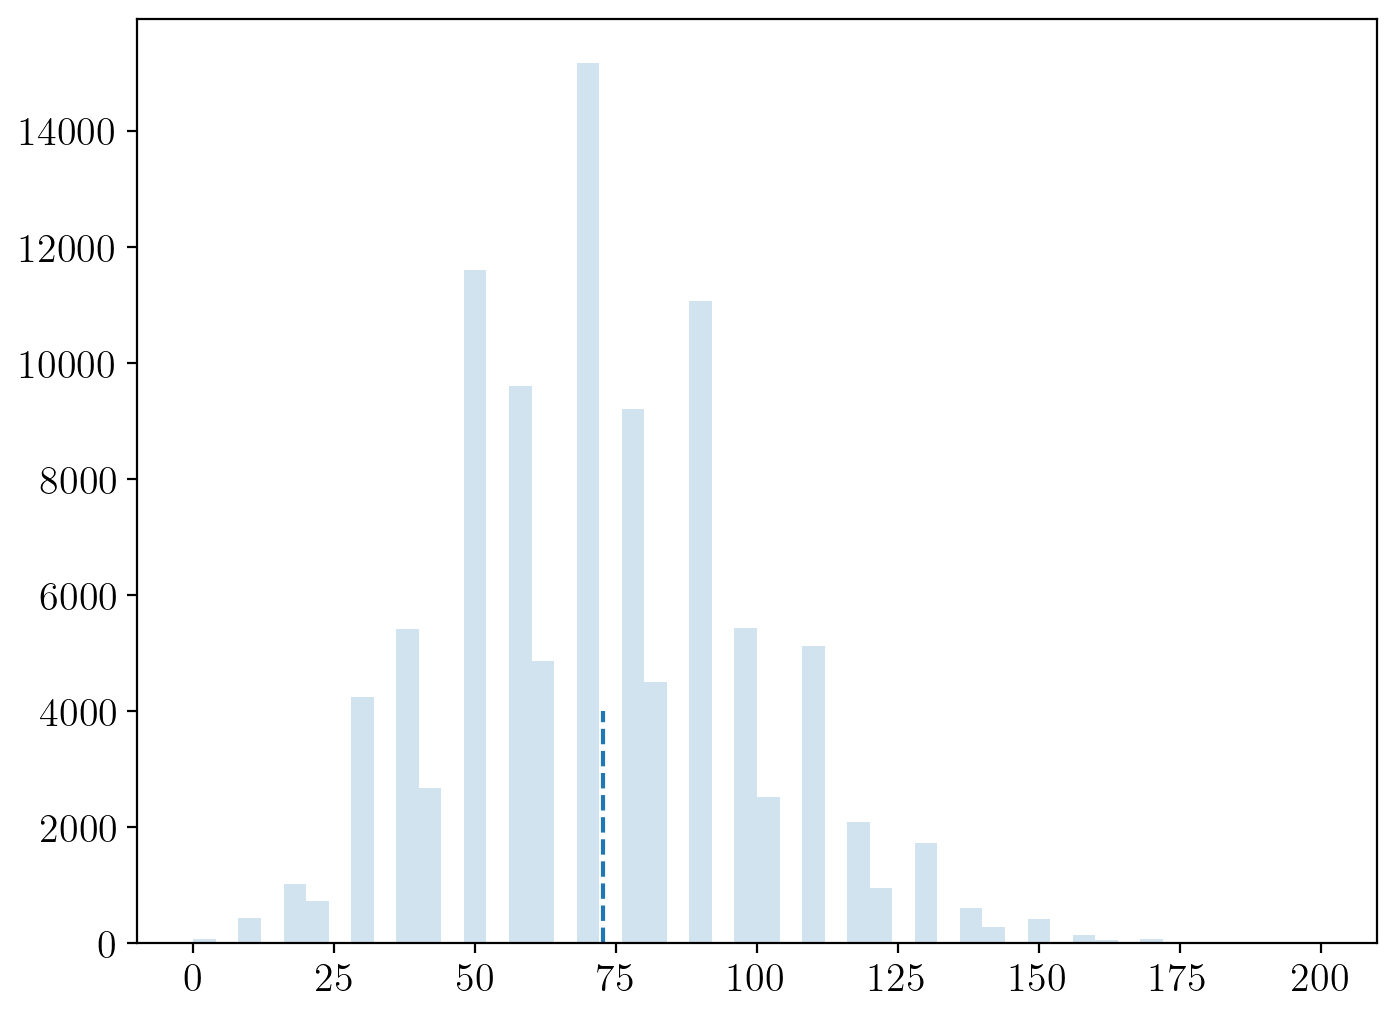

In [12]:
plt.hist(cash, bins = 50, alpha = 0.2, color = 'tab:blue')
plt.vlines(x = np.mean(cash), ymin=0,ymax=4000, color='tab:blue', linestyles='--')
plt.show()

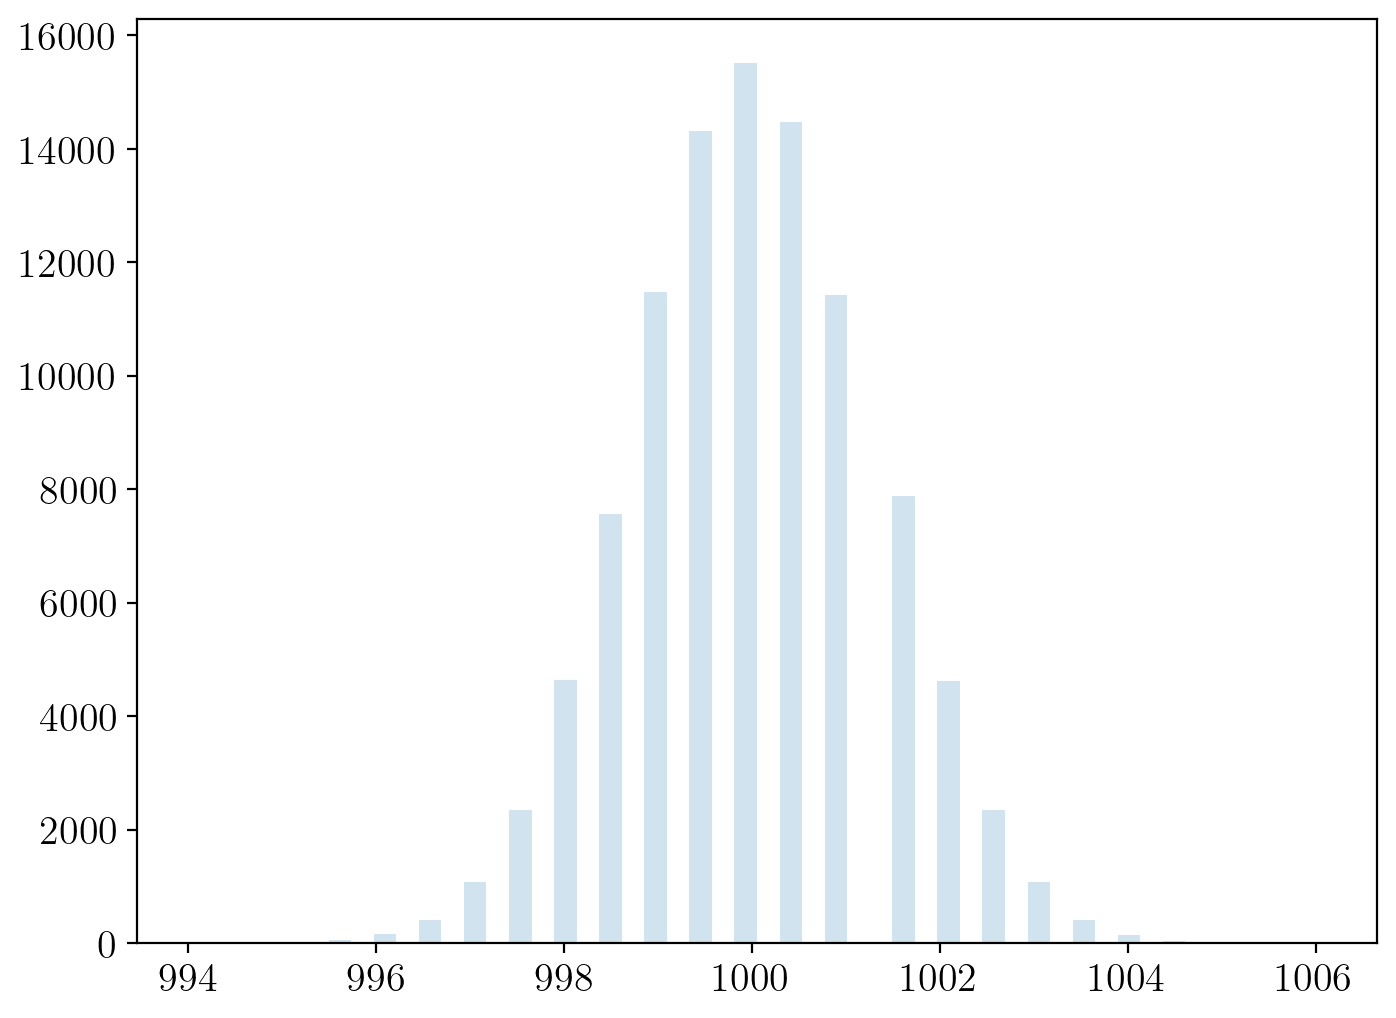

In [14]:
plt.hist(AMM.y_grid[idx_quantity], bins = 50, alpha = 0.2, color = 'tab:blue')
plt.show()

In [13]:
nsims = 100_000

In [14]:
cash_optimal,n_s_optimal,n_b_optimal, inventory  = AMM.simulate_cash_opt(nsims, dt=0.01)
cash_linear,n_s_linear,n_b_linear, inventory_linear = AMM.simulate_cash_linear(nsims, dt=0.01)

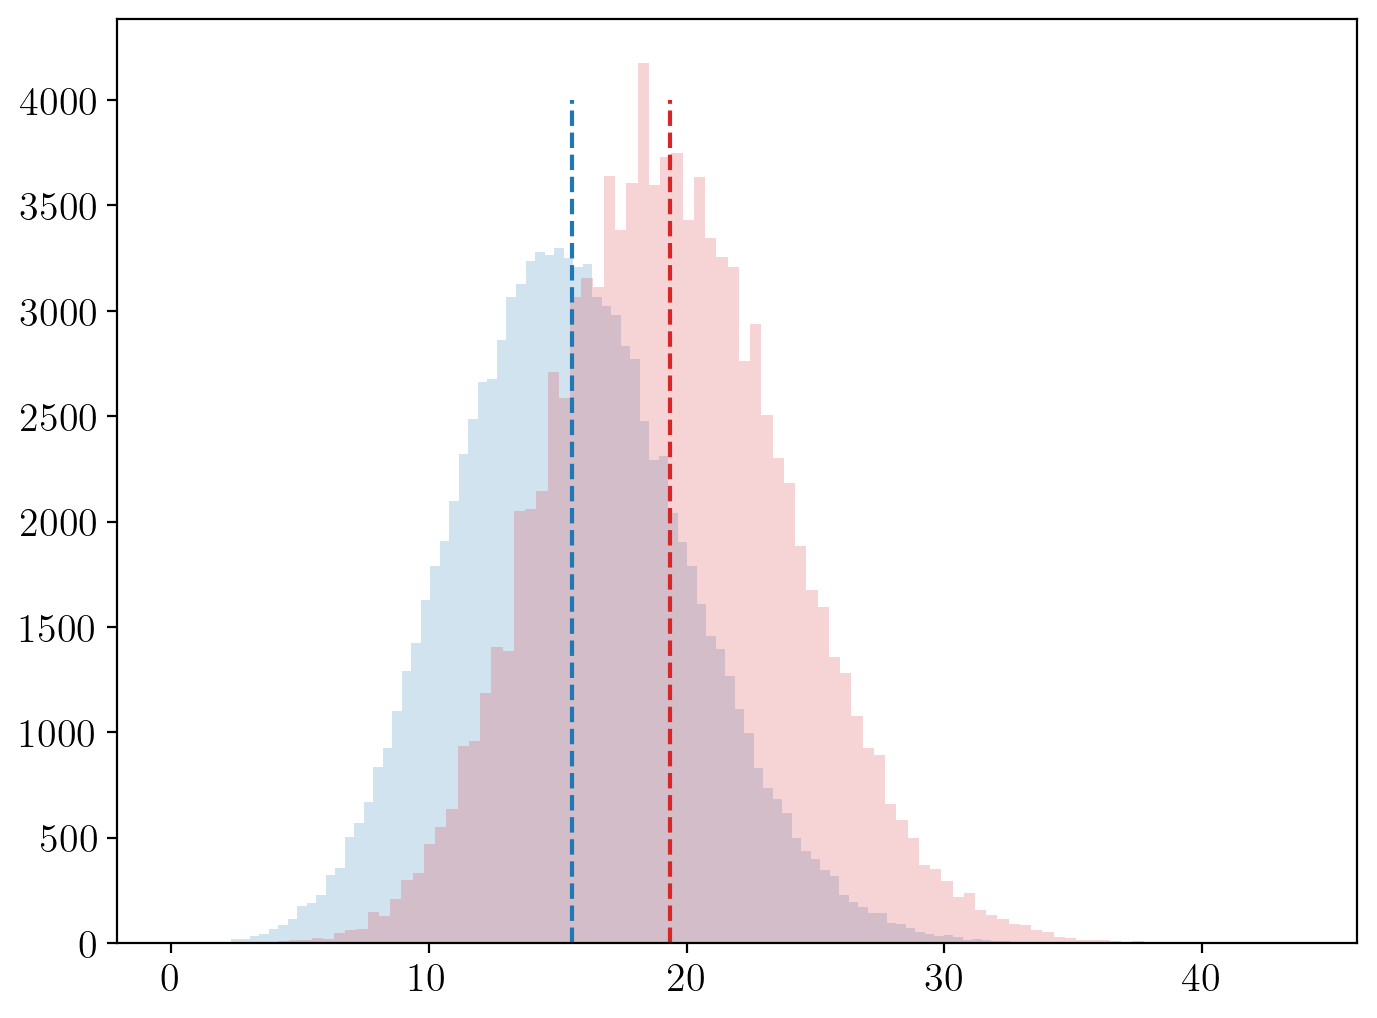

In [16]:
plt.hist(cash_optimal, bins = 100, alpha = 0.2, color = 'tab:blue')
plt.vlines(x = np.mean(cash_optimal), ymin=0,ymax=4000, color='tab:blue', linestyles='--')
plt.hist(cash_linear, bins = 100,alpha = 0.2, color = 'tab:red')
plt.vlines(x = np.mean(cash_linear), ymin=0,ymax=4000, color='tab:red', linestyles='--')
plt.show()

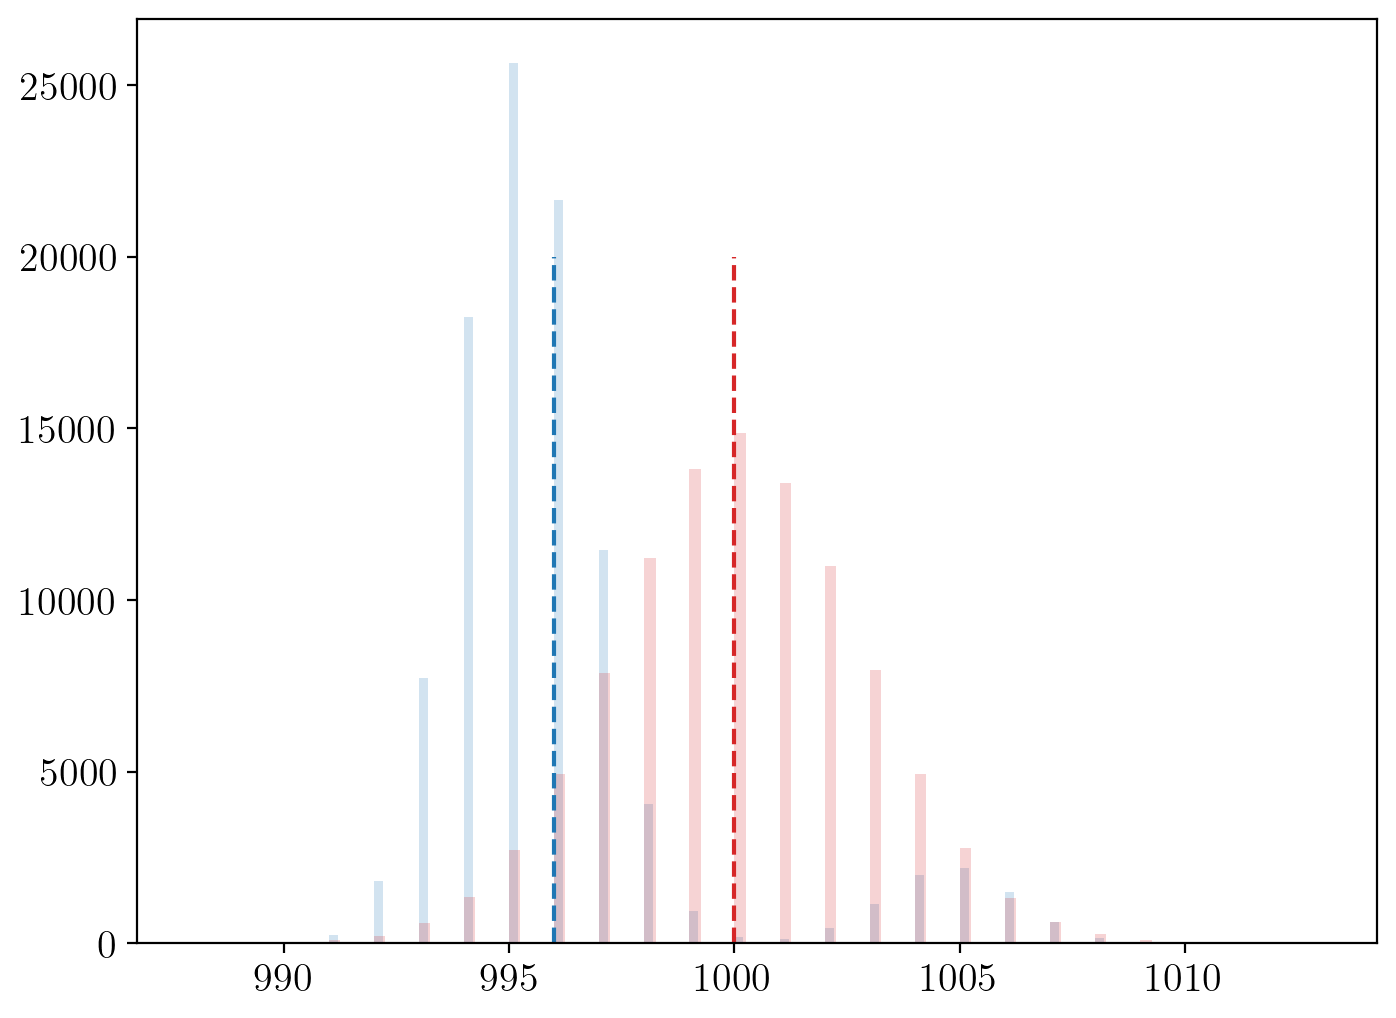

In [19]:
plt.hist(inventory, bins = 100, alpha = 0.2, color = 'tab:blue')
plt.vlines(x = np.mean(inventory), ymin=0,ymax=20000, color='tab:blue', linestyles='--')
plt.hist(inventory_linear, bins = 100,alpha = 0.2, color = 'tab:red')
plt.vlines(x = np.mean(inventory_linear), ymin=0,ymax=20000, color='tab:red', linestyles='--')
plt.show()

In [770]:
cash = [cash_optimal,cash_linear]
n_buy = [n_b_optimal,n_b_linear]
n_sell = [n_s_optimal,n_s_linear]


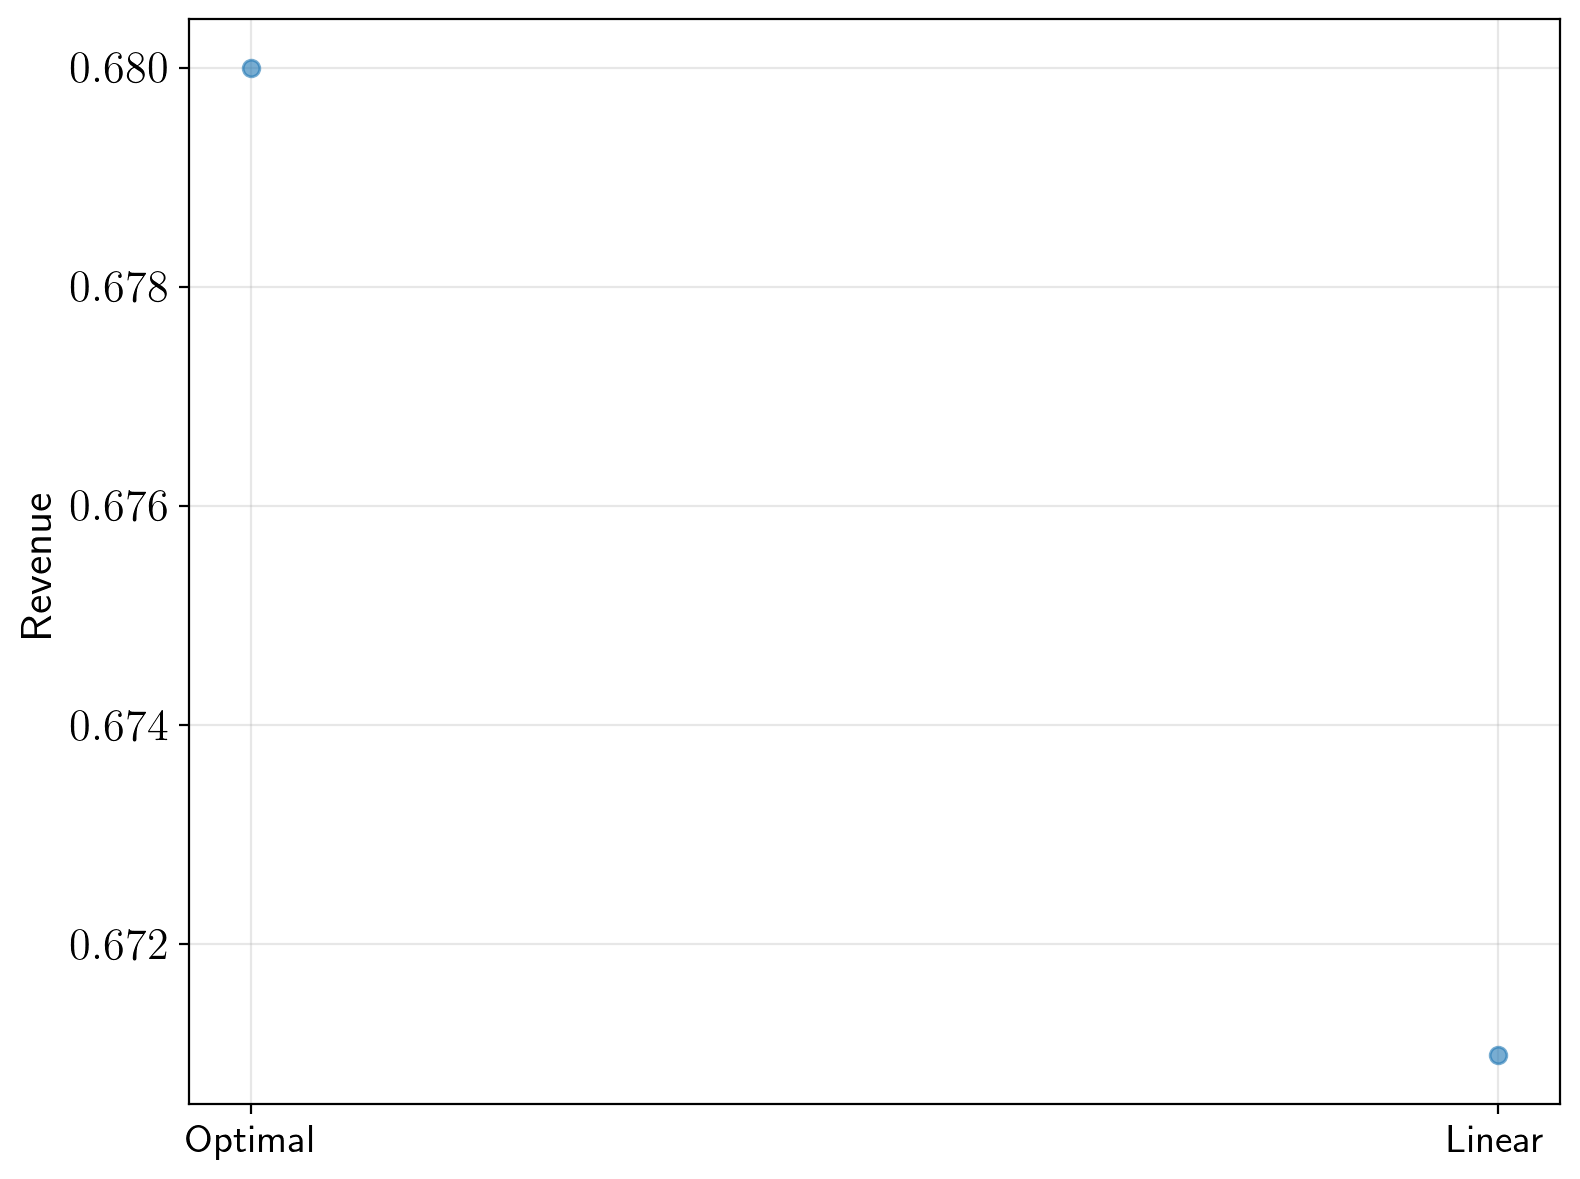

In [771]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

x_axis = ["Optimal", "Linear"]
ax.plot(x_axis, cash, "o", color='tab:blue', alpha=0.6)

plt.grid(alpha=0.3)
#plt.xlabel(x_axis, fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel("Revenue", fontsize=fs)

plt.tight_layout()
#plt.savefig('figures_2/approx_opt_fees.pdf', format="pdf", dpi=dpi)
plt.show()

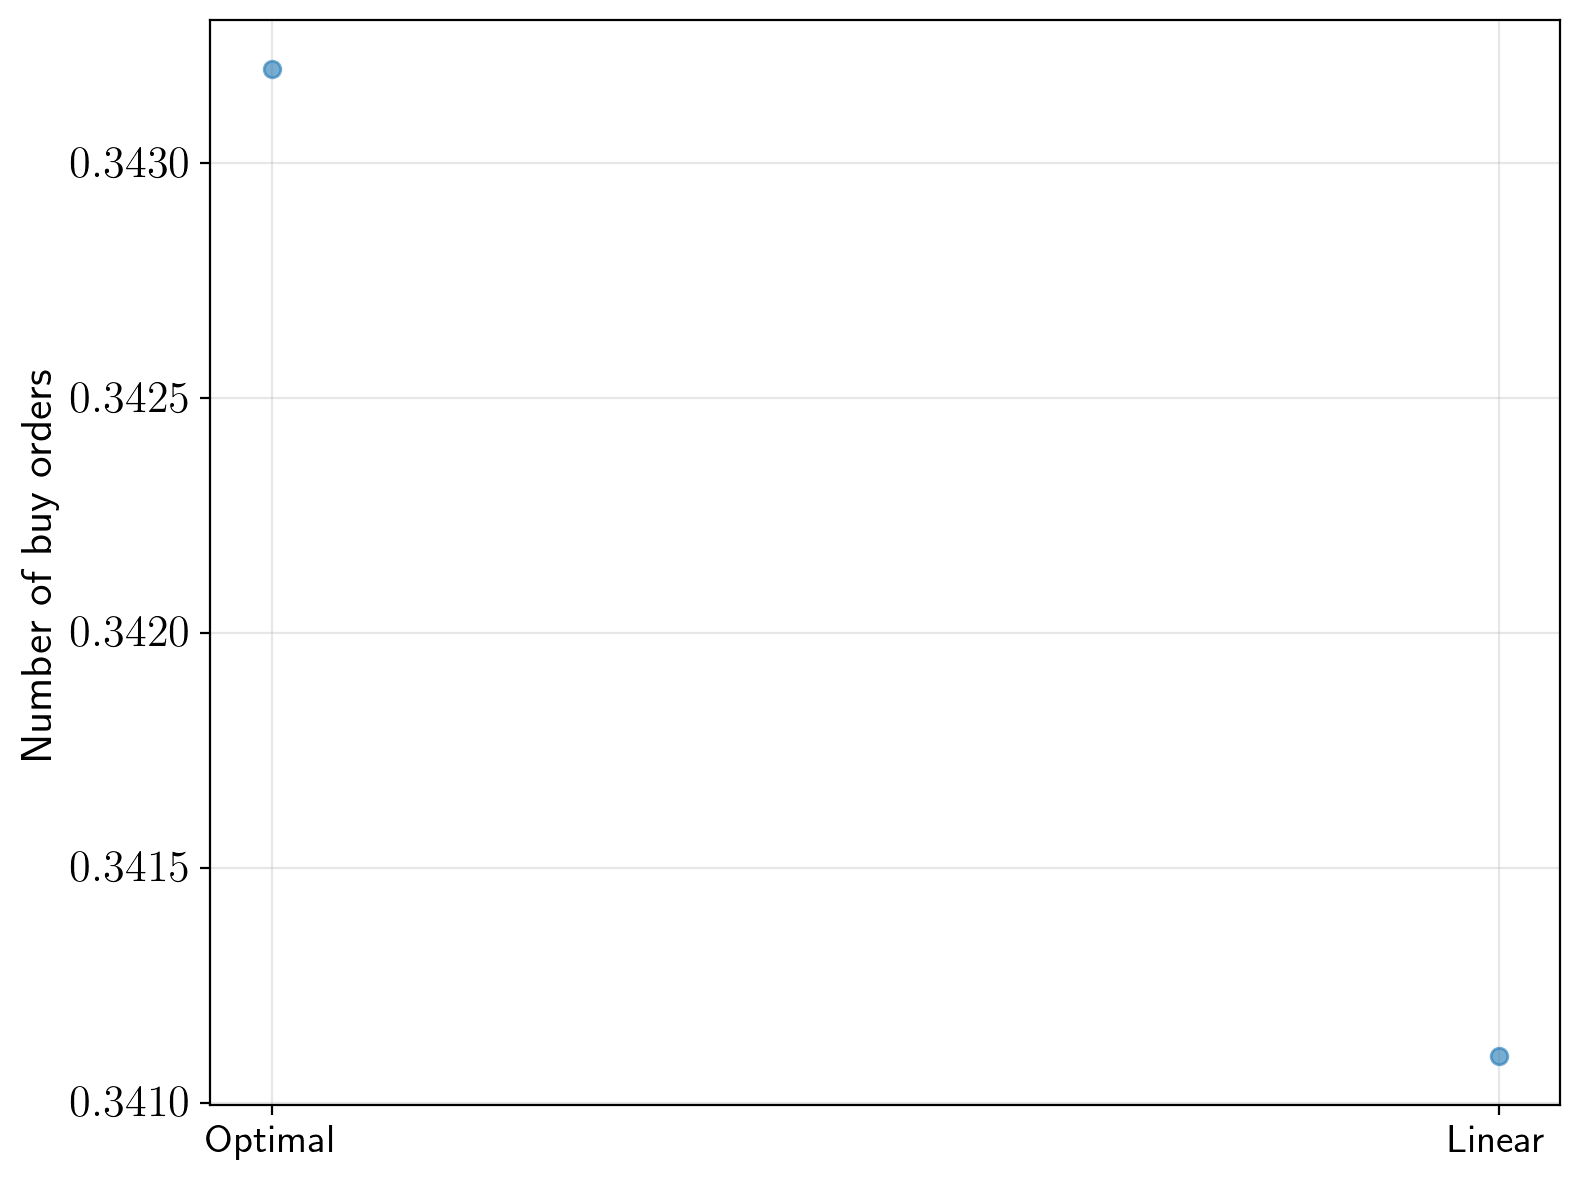

In [772]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

x_axis = ["Optimal", "Linear"]
ax.plot(x_axis, n_buy, "o", color='tab:blue', alpha=0.6)

plt.grid(alpha=0.3)
#plt.xlabel(x_axis, fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel("Number of buy orders", fontsize=fs)

plt.tight_layout()
#plt.savefig('figures_2/approx_opt_fees.pdf', format="pdf", dpi=dpi)
plt.show()

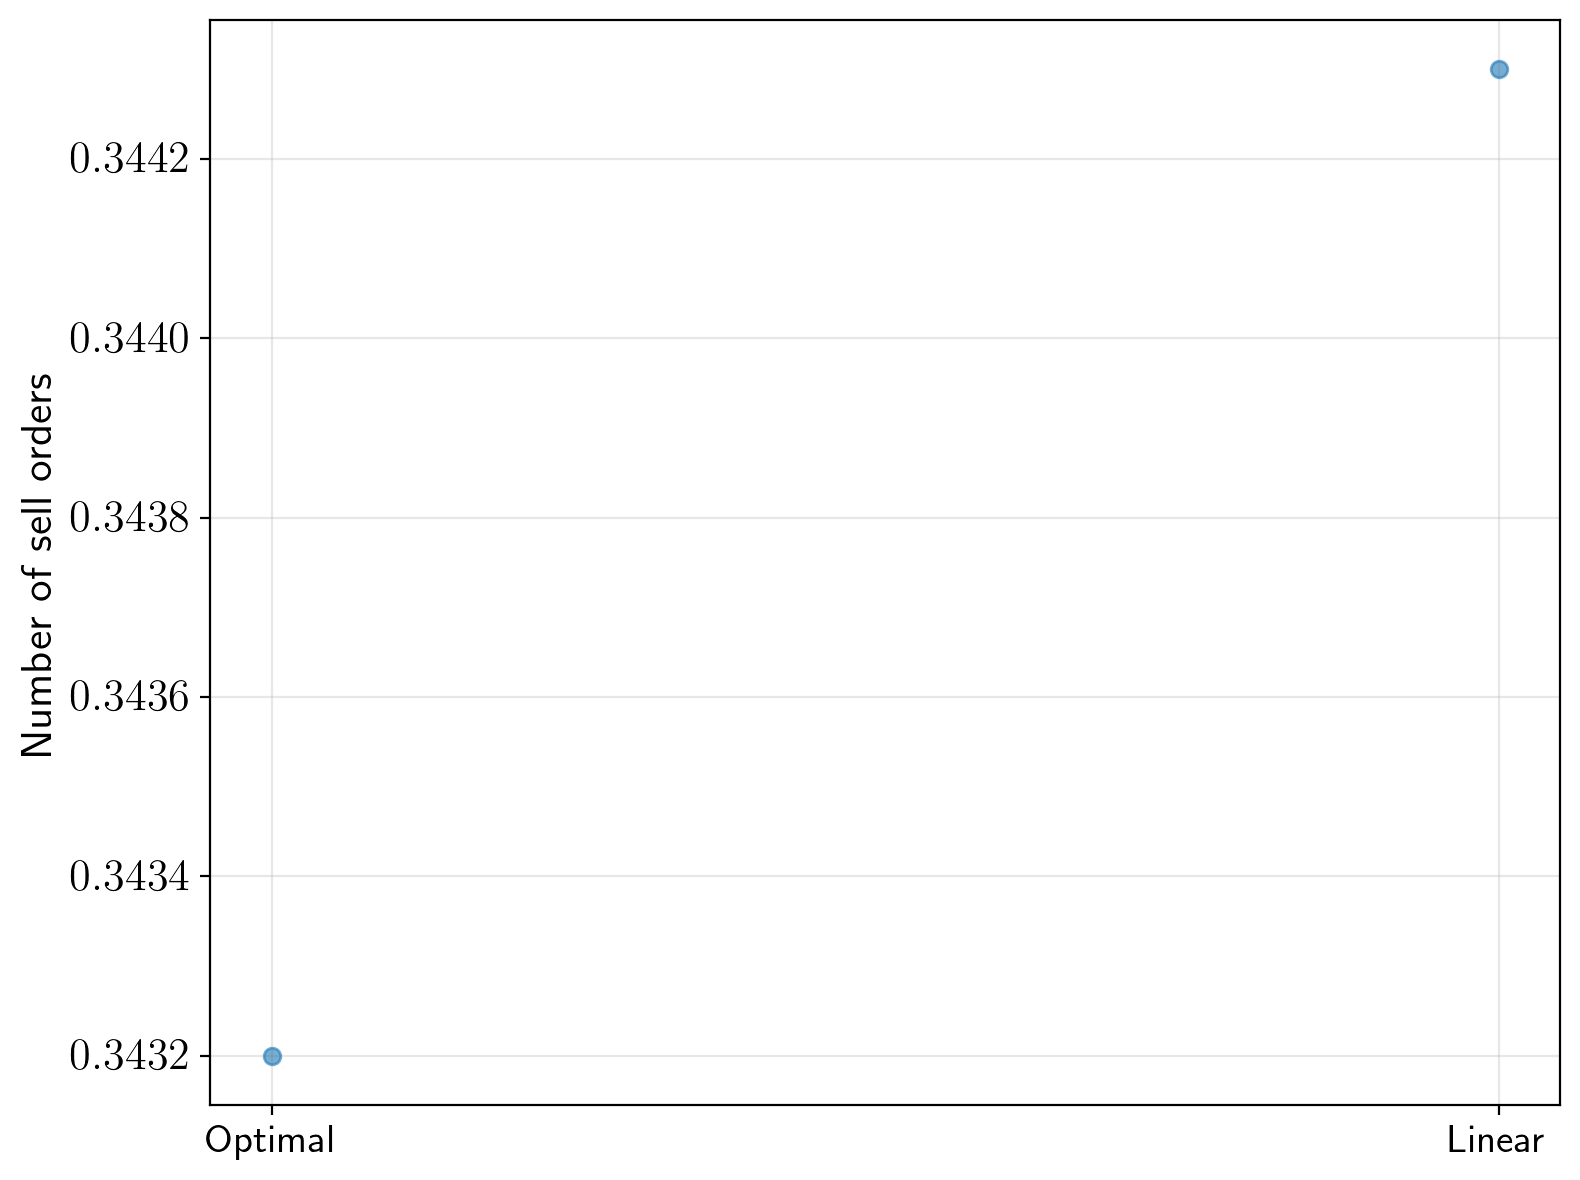

In [773]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

x_axis = ["Optimal", "Linear"]
ax.plot(x_axis, n_sell, "o", color='tab:blue', alpha=0.6)

plt.grid(alpha=0.3)
#plt.xlabel(x_axis, fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel("Number of sell orders", fontsize=fs)

plt.tight_layout()
#plt.savefig('figures_2/approx_opt_fees.pdf', format="pdf", dpi=dpi)
plt.show()

In [774]:
import pandas as pd

In [775]:
df = pd.DataFrame({
    "Fees" : x_axis,
    "Revenue": cash,
    "N of buy orders": n_buy,
    "N of sell orders": n_sell,
})

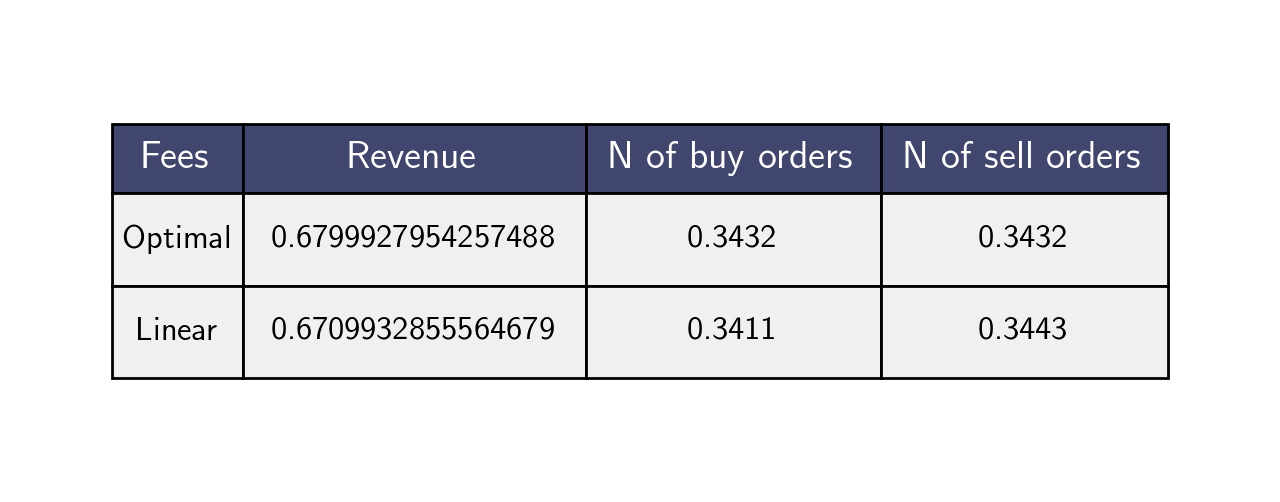

In [776]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 3))  # Keep image compact
ax.axis('off')  # Hide axis

# Define table colors
header_color = '#40466e'  # Dark blue for header
text_color = 'white'  # White text for header
row_color = '#F0F0F0'  # Light gray for rows

# Create table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colColours=[header_color] * len(df.columns)  # Header color
)

# Style table
table.auto_set_font_size(False)
table.set_fontsize(12)  # Bigger text
table.auto_set_column_width(col=list(range(len(df.columns))))  # Auto column width

# Add more padding between rows (increase row height)
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.set_text_props(weight='bold', color=text_color)
        cell.set_fontsize(14)  # Bigger header text
        cell.set_height(0.15)  # Make header taller
    else:  # Data rows
        cell.set_facecolor(row_color)  # Alternating row color
        cell.set_fontsize(12)  # Bigger text
        cell.set_height(0.2)  # More row height for spacing

    cell.set_edgecolor('black')  # Normal border thickness